In [1]:
import gym
import random
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from collections import deque
print("Gym:", gym.__version__)
print("Tensorflow:", tf.__version__)

Instructions for updating:
non-resource variables are not supported in the long term
Gym: 0.21.0
Tensorflow: 2.5.0


In [2]:
env_name = "CartPole-v0"
env = gym.make(env_name)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)


In [3]:
class QNetwork():
    def __init__(self, state_dim, action_size):
        self.state_in = tf.placeholder(tf.float32, shape=[None, *state_dim])
        self.action_in = tf.placeholder(tf.int32, shape=[None])
        self.q_target_in = tf.placeholder(tf.float32, shape=[None])
        action_one_hot = tf.one_hot(self.action_in, depth=action_size)
        
        self.hidden1 = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu)
        self.q_state = tf.layers.dense(self.hidden1, action_size, activation=None)
        self.q_state_action = tf.reduce_sum(tf.multiply(self.q_state, action_one_hot), axis=1)
        
        self.loss = tf.reduce_mean(tf.square(self.q_state_action - self.q_target_in))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)
        
    def update_model(self, session, state, action, q_target):
        feed = {self.state_in: state, self.action_in: action, self.q_target_in: q_target}
        session.run(self.optimizer, feed_dict=feed)
        
    def get_q_state(self, session, state):
        q_state = session.run(self.q_state, feed_dict={self.state_in: state})
        return q_state

In [4]:
class ReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

In [5]:
class DQNAgent():
    def __init__(self, env):
        self.state_dim = env.observation_space.shape
        self.action_size = env.action_space.n
        self.q_network = QNetwork(self.state_dim, self.action_size)
        self.replay_buffer = ReplayBuffer(maxlen=10000)
        self.gamma = 0.97
        self.eps = 1.0
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def get_action(self, state):
        q_state = self.q_network.get_q_state(self.sess, [state])
        action_greedy = np.argmax(q_state)
        action_random = np.random.randint(self.action_size)
        action = action_random if random.random() < self.eps else action_greedy
        return action
    
    def train(self, state, action, next_state, reward, done):
        self.replay_buffer.add((state, action, next_state, reward, done))
        states, actions, next_states, rewards, dones = self.replay_buffer.sample(50)
        q_next_states = self.q_network.get_q_state(self.sess, next_states)
        q_next_states[dones] = np.zeros([self.action_size])
        q_targets = rewards + self.gamma * np.max(q_next_states, axis=1)
        self.q_network.update_model(self.sess, states, actions, q_targets)
        
        if done: self.eps = max(0.1, 0.99*self.eps)
    
    def __del__(self):
        self.sess.close()

In [21]:
agent = DQNAgent(env)
num_episodes = 400
total_reward_array=[]
for ep in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        agent.train(state, action, next_state, reward, done)
        env.render()
        total_reward += reward
        state = next_state
    total_reward_array.append(total_reward)
    print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))

Episode: 0, total_reward: 20.00
Episode: 1, total_reward: 27.00
Episode: 2, total_reward: 30.00
Episode: 3, total_reward: 26.00
Episode: 4, total_reward: 40.00
Episode: 5, total_reward: 16.00
Episode: 6, total_reward: 36.00
Episode: 7, total_reward: 16.00
Episode: 8, total_reward: 32.00
Episode: 9, total_reward: 18.00
Episode: 10, total_reward: 28.00
Episode: 11, total_reward: 21.00
Episode: 12, total_reward: 9.00
Episode: 13, total_reward: 14.00
Episode: 14, total_reward: 22.00
Episode: 15, total_reward: 11.00
Episode: 16, total_reward: 15.00
Episode: 17, total_reward: 15.00
Episode: 18, total_reward: 10.00
Episode: 19, total_reward: 15.00
Episode: 20, total_reward: 16.00
Episode: 21, total_reward: 13.00
Episode: 22, total_reward: 25.00
Episode: 23, total_reward: 20.00
Episode: 24, total_reward: 14.00
Episode: 25, total_reward: 14.00
Episode: 26, total_reward: 22.00
Episode: 27, total_reward: 43.00
Episode: 28, total_reward: 15.00
Episode: 29, total_reward: 25.00
Episode: 30, total_re

In [22]:
env.close()

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
len(total_reward_array)

400

<function matplotlib.pyplot.show(close=None, block=None)>

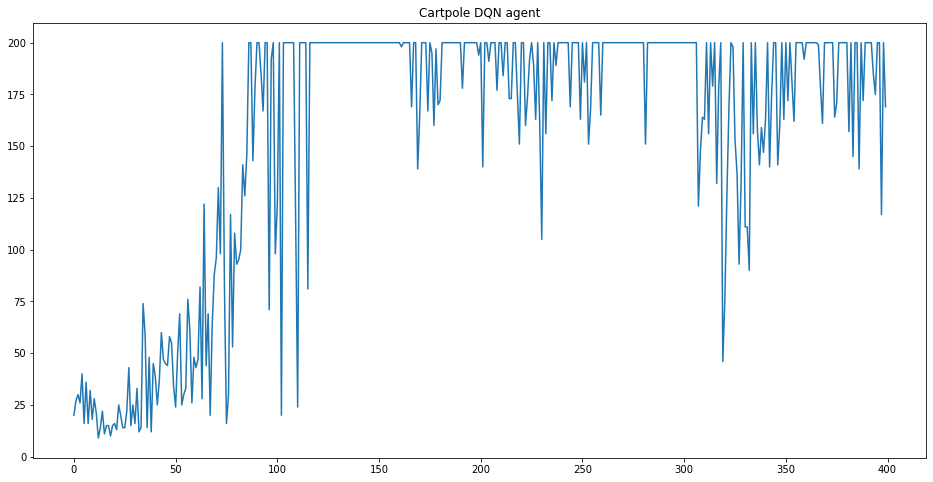

In [25]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x=range(0,400), y= total_reward_array, ax=ax)
plt.title('Cartpole DQN agent')
plt.show